# MNIST Autoencoder

Based on https://github.com/L1aoXingyu/pytorch-beginner/blob/master/08-AutoEncoder/conv_autoencoder.py

In [1]:
%matplotlib inline

In [30]:
import tqdm
import torch
import random
import math

from tqdm.notebook import tqdm, tnrange
import numpy as np
from PIL import Image

import torch
from torch import nn, optim, Tensor
from torch.nn import functional as F
from torch.autograd import Variable, grad
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets, transforms, utils
from torchvision.utils import save_image
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
from PIL import Image
import PIL.ImageFilter as ImageFilter

mpl.rcParams['figure.figsize'] = [10.0, 10.0]

In [5]:
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x

In [6]:
num_epochs = 100
batch_size = 128
learning_rate = 1e-3

In [16]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [17]:
dataset = MNIST('~/data', transform=img_transform)  # Add download=True if you're doing it your first time
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [11]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1),  # b, 16, 10, 10
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)  # b, 8, 2, 2
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, stride=2),  # b, 16, 5, 5
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),  # b, 8, 15, 15
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),  # b, 1, 28, 28
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [12]:
model = autoencoder().cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                             weight_decay=1e-5)

In [35]:
def train_epoch(model, dataloader, criterion, optimizer):
    for data in tqdm(dataloader, leave=False):
        img, _ = data
        img = Variable(img).cuda()
        # ===================forward=====================
        output = model(img)
        loss = criterion(output, img)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return loss.item()

In [27]:
train_epoch(model, dataloader, criterion, optimizer)

0.16849449276924133

In [36]:
losses = []
for epoch in tnrange(num_epochs):
    loss = train_epoch(model, dataloader, criterion, optimizer)
    losses.append(loss)

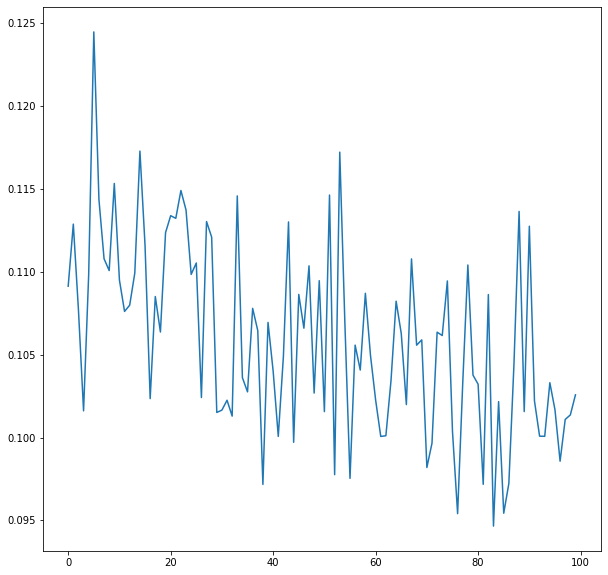

In [40]:
plt.plot(np.asarray(losses))

In [46]:
mean = (0.5,)
stddev = (0.5,)

def to_t_shape(data, shape):
    return Tensor(data).view(*shape)

tmean = to_t_shape(mean, (-1, 1, 1))
tstd = to_t_shape(stddev, (-1, 1, 1))

def unnormalize(image, mean, std):
    image = ((image * std) + mean)
    return image

def view(tensor):
    tensor = tensor.detach().cpu()
    tensor = unnormalize(tensor, tmean, tstd).permute(1, 2, 0)
    tensor = tensor.numpy()
    return plt.imshow(tensor)

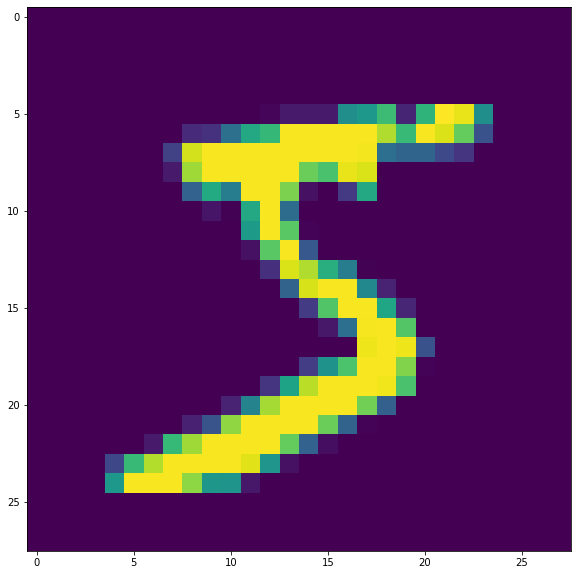

In [49]:
plt.imshow(dataset[0][0][0])

In [54]:
output = model(dataset[0][0].view(1, 1, 28, 28).cuda())


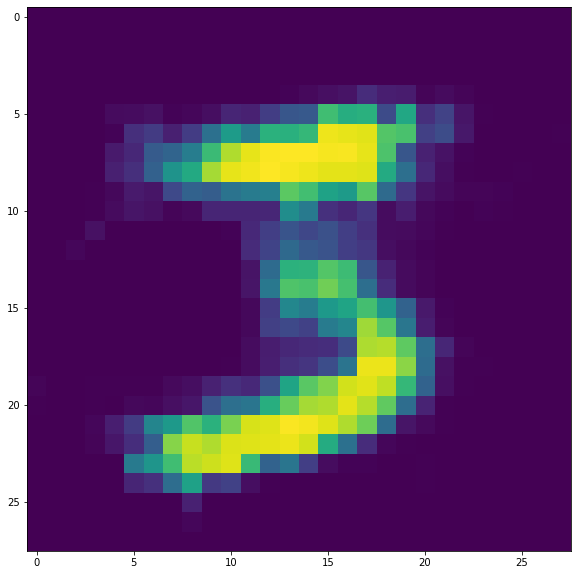

In [56]:
plt.imshow(output.detach().cpu()[0][0])

In [57]:
for epoch in tnrange(10):
    loss = train_epoch(model, dataloader, criterion, optimizer)
    losses.append(loss)